In [2]:
import pickle

with open('CrytoNewsData.pickle', 'rb') as file:
    data = pickle.load(file)

In [3]:
data[0]

{'news_url': 'https://cryptonews.com/news/bitcoin-and-altcoins-target-fresh-highs-in-new-year-8783.htm',
 'image_url': 'https://crypto.snapi.dev/images/v1/0/a/ebd061a02e.jpg',
 'title': 'Bitcoin and Altcoins Target Fresh Highs In New Year',
 'text': 'Bitcoin price seems to be aiming more upsides above USD 29,500 and USD 30,000.',
 'source_name': 'Cryptonews',
 'date': 'Fri, 01 Jan 2021 01:08:00 -0500',
 'topics': ['bitcoin'],
 'sentiment': 'Positive',
 'type': 'Article',
 'tickers': ['BTC'],
 'prices': {'before': array([28934.84, 28900.  , 28858.94, 28848.69, 28824.36, 28838.69,
         28716.85, 28752.8 , 28769.77, 28812.34, 28800.58, 28823.21,
         28822.17, 28757.97, 28796.23, 28796.56, 28835.01, 28844.88,
         28871.28, 28844.48, 28839.58, 28833.73, 28836.63, 28876.31,
         28858.53, 28872.49, 28890.  , 28879.48, 28931.41, 28928.7 ,
         28914.15, 28901.91, 28897.97, 28927.33, 28913.32, 28919.99,
         28916.97, 28930.11, 28894.5 , 28929.09, 28938.76, 28939.6 ,


In [6]:
from tqdm.auto import tqdm
import numpy as np

sentences = []
labels = []


for i in tqdm(range(len(data))):
    before_percent = 100 * (np.max(data[i]['prices']['before']) - np.min(data[i]['prices']['before'])) / np.min(data[i]['prices']['before'])
    before_volume = np.max(data[i]['volumes']['before']) / np.mean(data[i]['volumes']['before'])
    if before_percent < 5 and before_volume < 5 and len(data[i]['text']) < 4000:
        first_increase = np.argmax(np.array(data[i]['prices']['after']) >= 1.01*data[i]['prices']['newstime'])
        if first_increase == 0:
            first_increase = float('inf')
            
        first_decrease = np.argmax(np.array(data[i]['prices']['after']) <= 0.99*data[i]['prices']['newstime'])
        if first_decrease == 0:
            first_decrease = float('inf')

        if first_increase < first_decrease or (first_increase == first_decrease == float('inf') and data[i]['prices']['after'][-1] > data[i]['prices']['newstime']):
            label = 1 #'Positive'
        #elif after_percent < -1:
        #    label = 1 #'Negative'
        else:
            label = 0 #'Neutral'
        
        news = data[i]['text']
        
        sentences.append(news)
        labels.append(label)
        #price_percents.append(first_increase)

  0%|          | 0/79449 [00:00<?, ?it/s]

In [7]:
sentences[2]

'According to the Galaxy Digital CEO, institutions have a greater opportunity to buy Bitcoin currently in circulation, driving up the price.'

In [8]:
labels[2]

0

(array([1302.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1490.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

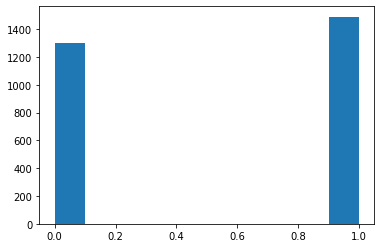

In [9]:
import matplotlib.pyplot as plt

plt.hist(labels)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.3, random_state=1)

In [10]:
len(X_train), len(X_test), len(y_train), len(y_test)

(1954, 838, 1954, 838)

In [11]:
X_train[0]

'Bitcoin marched into the third month of Q3 on a high. Following a correction of over 40% in Q2, many in the community now anticipate the king coin will soon breach its previous ATH.'

In [12]:
import re

# Pre-processing (clean the text by removing special characters, punctuations, and numbers)
X_train = [re.sub("[^a-zA-Z]"," ", s).lower() for s in X_train]
X_test = [re.sub("[^a-zA-Z]"," ", s).lower() for s in X_test]

In [13]:
X_train[0]

'bitcoin marched into the third month of q  on a high  following a correction of over     in q   many in the community now anticipate the king coin will soon breach its previous ath '

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [15]:
countvector = CountVectorizer(ngram_range=(1,2))
X_train_bow = countvector.fit_transform(X_train).toarray().astype("float32")
X_test_bow = countvector.transform(X_test).toarray().astype("float32")
X_train_bow.shape, X_test_bow.shape

((1954, 42929), (838, 42929))

In [16]:
#from sklearn.preprocessing import normalize

#X_train_bow = normalize(X_train_bow)
#X_test_bow = normalize(X_test_bow)

In [17]:
from torch.utils.data import Dataset, DataLoader

class CrytoNewsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y 

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [233]:
train_dataset = CrytoNewsDataset(X_train_bow, y_train)
test_dataset = CrytoNewsDataset(X_test_bow, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [272]:
import torch
from torch import nn

device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.manual_seed(1)
model = nn.Sequential(
            nn.Linear(X_train_bow.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2),
        ).to(device)

In [273]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay=10)

num_epochs = 10
num_training_steps = num_epochs * len(train_dataloader)

In [274]:
class Average:
    def __init__(self):
        self.avg = 0
        self.size = 0
    
    def update(self, value, size):
        self.avg = (self.avg*self.size + value*size) / (self.size + size)
        self.size += size
    
    def item(self):
        return self.avg

In [275]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weight

array([1.06775956, 0.94032724])

In [276]:
from tqdm.auto import tqdm


progress_bar = tqdm(range(num_training_steps))
loss_func = torch.nn.CrossEntropyLoss(weight=torch.tensor(list(weight), dtype=torch.float32, device=device))
model.train()
losses = []
accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
    loss_avg = Average()
    acc_avg = Average()
    for X,y in train_dataloader:
        y_pred = model(X.to(device))
        loss = loss_func(y_pred, y.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            loss_avg.update(loss.item(), len(y))
            acc = torch.sum(y_pred.argmax(axis=1) == y.to(device))
            acc_avg.update(acc.item()/len(y), len(y))

        progress_bar.update(1)
        progress_bar.set_description(f"Loss: {loss_avg.item():.3f}, Acc: {acc_avg.item():.3f}")

    
    test_loss_avg = Average()
    test_acc_avg = Average()
    with torch.no_grad():
        for X,y in test_dataloader:
            y_pred = model(X.to(device))
            loss = loss_func(y_pred, y.to(device))
            test_loss_avg.update(loss.item(), len(y))
            acc = torch.sum(y_pred.argmax(axis=1) == y.to(device))
            test_acc_avg.update(acc.item()/len(y), len(y))

    losses.append(loss_avg.item())
    accs.append(acc_avg.item())
    test_losses.append(test_loss_avg.item())
    test_accs.append(test_acc_avg.item())
    print(f"[EPOCH {epoch}] Loss: {loss_avg.item():.3f}, Acc: {acc_avg.item():.3f}, Test Loss: {test_loss_avg.item():.3f}, Test Acc: {test_acc_avg.item():.3f}")

  0%|          | 0/310 [00:00<?, ?it/s]

[EPOCH 0] Loss: 0.694, Acc: 0.468, Test Loss: 0.695, Test Acc: 0.462
[EPOCH 1] Loss: 0.689, Acc: 0.468, Test Loss: 0.694, Test Acc: 0.462
[EPOCH 2] Loss: 0.683, Acc: 0.497, Test Loss: 0.694, Test Acc: 0.462
[EPOCH 3] Loss: 0.673, Acc: 0.621, Test Loss: 0.693, Test Acc: 0.488
[EPOCH 4] Loss: 0.658, Acc: 0.766, Test Loss: 0.692, Test Acc: 0.488
[EPOCH 5] Loss: 0.638, Acc: 0.874, Test Loss: 0.692, Test Acc: 0.511
[EPOCH 6] Loss: 0.614, Acc: 0.941, Test Loss: 0.691, Test Acc: 0.526
[EPOCH 7] Loss: 0.586, Acc: 0.960, Test Loss: 0.691, Test Acc: 0.542
[EPOCH 8] Loss: 0.554, Acc: 0.976, Test Loss: 0.691, Test Acc: 0.541
[EPOCH 9] Loss: 0.519, Acc: 0.983, Test Loss: 0.691, Test Acc: 0.547


In [277]:
with torch.no_grad():
    predictions = model(torch.from_numpy(X_test_bow).to(device)).argmax(axis=1).cpu().numpy()

In [278]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
score = accuracy_score(y_test,predictions)
print(score)
report = classification_report(y_test,predictions)
print(report)

0.5465393794749404
              precision    recall  f1-score   support

           0       0.51      0.57      0.54       387
           1       0.59      0.53      0.56       451

    accuracy                           0.55       838
   macro avg       0.55      0.55      0.55       838
weighted avg       0.55      0.55      0.55       838

